In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats

In [28]:
# paths
local_path = '/project/data/ABCD/training_output/'
participants_tsv = local_path + 'participants_ABCD.tsv' 
testing_participants_tsv = local_path + 'test_participants_ABCD.tsv' 
likelihoods_npy = local_path + 'likelihood.npy'

In [39]:
likelihoods_tensor = np.load(likelihoods_npy, allow_pickle=True)
likelihoods = list(map(lambda x: x.numpy()[0], likelihoods_tensor))

df_all = pd.read_csv(participants_tsv, sep='\t', header=0)
df_test = pd.read_csv(testing_participants_tsv, sep='\t', header=0)

df_test['likelihood'] = likelihoods

df = pd.merge(df_test, df_all,
              on=['participant_id','session_id','run_id'], 
              how='inner', suffixes=('_x2', '_y2'))

df['cbcl_bin'] = df['cbcl_scr_syn_totprob_r'] > 25 #cbcl quantile for first 75% examples

In [61]:
print('Low cbcl:',df[df['cbcl_bin']==0]['likelihood'].mean())
print('High cbcl:',df[df['cbcl_bin']==1]['likelihood'].mean())

Low cbcl: -11115.577
High cbcl: -11112.922


In [66]:
df.columns.to_list()

['participant_id',
 'session_id',
 'run_id',
 'age_x2',
 'sex_x2',
 'dataset_x2',
 'likelihood',
 'collection_id_x',
 'abcd_cbcls01_id',
 'dataset_id_x',
 'subjectkey',
 'src_subject_id_x',
 'interview_date_x',
 'interview_age_x',
 'sex_x',
 'eventname_x',
 'cbcl_scr_syn_anxdep_r',
 'cbcl_scr_syn_anxdep_t',
 'cbcl_scr_syn_anxdep_m',
 'cbcl_scr_syn_anxdep_nm',
 'cbcl_scr_syn_withdep_r',
 'cbcl_scr_syn_withdep_t',
 'cbcl_scr_syn_withdep_m',
 'cbcl_scr_syn_withdep_nm',
 'cbcl_scr_syn_somatic_r',
 'cbcl_scr_syn_somatic_t',
 'cbcl_scr_syn_somatic_m',
 'cbcl_scr_syn_somatic_nm',
 'cbcl_scr_syn_social_r',
 'cbcl_scr_syn_social_t',
 'cbcl_scr_syn_social_m',
 'cbcl_scr_syn_social_nm',
 'cbcl_scr_syn_thought_r',
 'cbcl_scr_syn_thought_t',
 'cbcl_scr_syn_thought_m',
 'cbcl_scr_syn_thought_nm',
 'cbcl_scr_syn_attention_r',
 'cbcl_scr_syn_attention_t',
 'cbcl_scr_syn_attention_m',
 'cbcl_scr_syn_attention_nm',
 'cbcl_scr_syn_rulebreak_r',
 'cbcl_scr_syn_rulebreak_t',
 'cbcl_scr_syn_rulebreak_m',
 '

In [77]:
x = df[df['cbcl_bin']==1]['cbcl_scr_syn_totprob_t']
y = df[df['cbcl_bin']==1]['likelihood']
r, pval = stats.pearsonr(x, y)
print('r:', r)
print('pval:', pval)

r: 0.05350735516452503
pval: 0.005514191521147578


(array([1306.,  594.,  362.,  211.,  103.,   59.,   28.,   16.,    5.,
           5.]),
 array([ 26. ,  37.3,  48.6,  59.9,  71.2,  82.5,  93.8, 105.1, 116.4,
        127.7, 139. ]),
 <BarContainer object of 10 artists>)

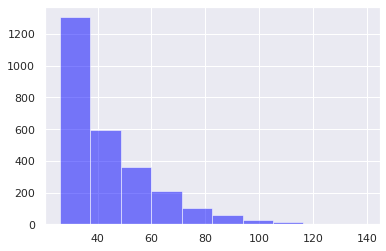

In [52]:
# hist1 = df[df['cbcl_bin']==0]['cbcl_scr_syn_totprob_r']
# hist2 = df[df['cbcl_bin']==1]['cbcl_scr_syn_totprob_r']
dist1 = df[df['cbcl_bin']==0]['likelihood']
# dist2 = df[df['cbcl_bin']==1]['likelihood']
dist2 = df[df['cbcl_bin']==1]['cbcl_scr_syn_totprob_r']

fig, ax = plt.subplots()
# ax.hist(dist1, color='green', alpha=0.5)
ax.hist(dist2, color='blue', alpha=0.5)

In [44]:
# print to screen and file at same time
def dual_print(f, *args, **kwargs): 
    print(*args, **kwargs) 
    print(*args, **kwargs, file=f)

n(total)= 3524 r= -0.011
n(False)= 835 r(False)= -0.002
n(True)= 2689 r(True)= -0.015

writing /project/data/ABCD/training_output/scatterplot.png
writing /project/data/ABCD/training_output/boxplot.png



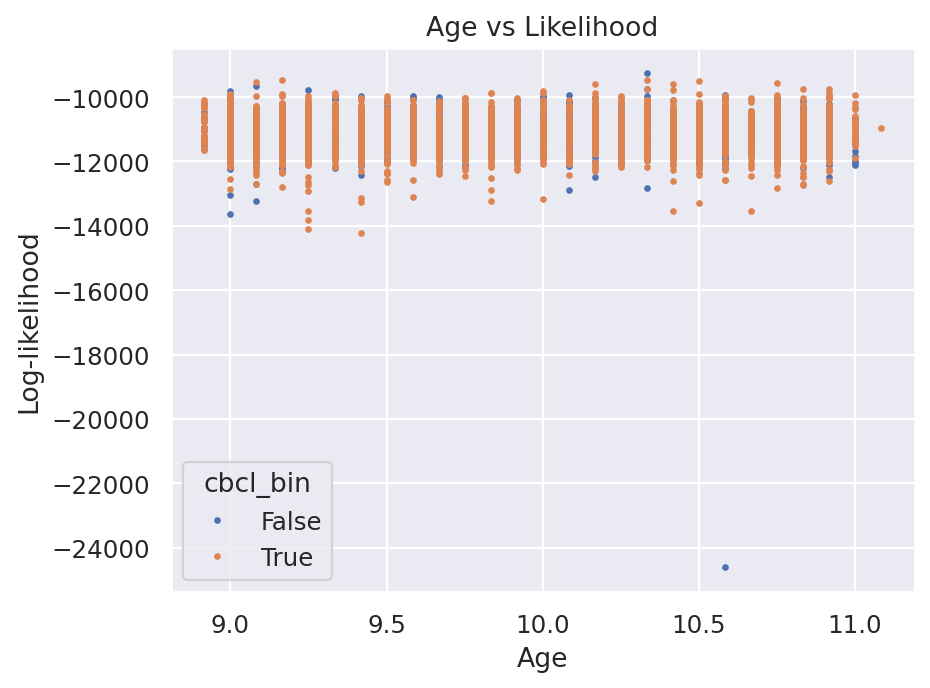

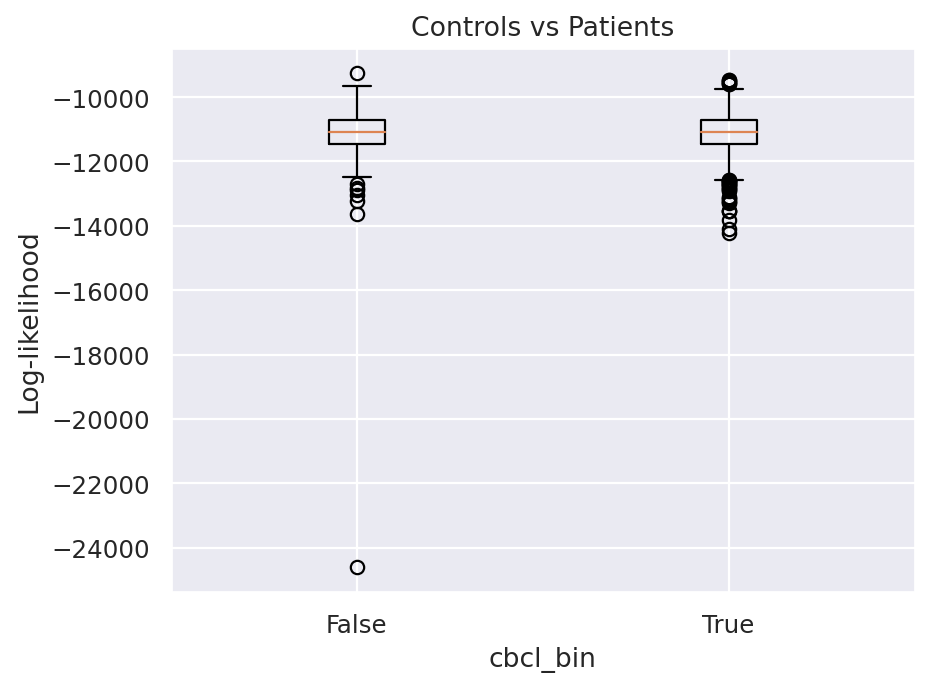

In [46]:
# make plots
sn.set_theme()
fig1, ax1 = plt.subplots(figsize=(6,4.5),dpi=160)
fig2, ax2 = plt.subplots(figsize=(6,4.5),dpi=160)

# print stats
f_out = open(local_path+'output.txt', 'w')
x = df['age_x2'].values
y = df['likelihood'].values
n = len(x)
r, _ = stats.pearsonr(x, y)
dual_print(f_out, 'n(total)=', n, 'r=', round(r,3))

# prepare data
boxp_data, boxp_names = [], []
for name, group in df.groupby('cbcl_bin'):
    x = group['age_x2'].values
    y = group['likelihood'].values
    n = len(group['age_x2'].values)
    r, _ = stats.pearsonr(x, y)
    boxp_data.append(y)
    boxp_names.append(name)
    dual_print(f_out, 'n('+str(name)+')=', n, 'r('+str(name)+')=', round(r,3))
    _ = ax1.plot(x, y, marker='.', linestyle='', markersize=4, label=name)

# scatter plot    
ax1.set_title('Age vs Likelihood')
ax1.set_ylabel('Log-likelihood')
ax1.set_xlabel('Age')    
ax1.legend(title='cbcl_bin')
ax1.grid(True)

# box plot
ax2.set_title('Controls vs Patients')
ax2.set_ylabel('Log-likelihood')
ax2.set_xlabel('cbcl_bin')
_ = ax2.boxplot(boxp_data)
_ = ax2.set_xticklabels(boxp_names)

# save png files
dual_print(f_out,'\nwriting ' + local_path + 'scatterplot.png')
fig1.savefig(local_path + 'scatterplot.png', bbox_inches='tight')
dual_print(f_out,'writing ' + local_path + 'boxplot.png\n')
fig2.savefig(local_path + 'boxplot.png', bbox_inches='tight')

f_out.close()